<a href="https://colab.research.google.com/github/Mayankjh/Classifications_deeplearning/blob/master/ChestXray_Penumonia_Classification_on_InceptionV3_(Adam_Optimizer).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
ls drive/'My Drive'/chest_xray11

test/  train/  val/


In [0]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("drive/My Drive/chest_xray11"))

from os import listdir, makedirs
from os.path import join, exists, expanduser

from keras.applications.inception_v3 import InceptionV3
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, GlobalAveragePooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import backend as K
import tensorflow as tf
from keras.utils.data_utils import Sequence
import sys
from PIL import *
sys.modules['Image'] = Image 
print(os.listdir("drive/My Drive/chest_xray11/train"))

['test', 'train', 'val', '.ipynb_checkpoints']


Using TensorFlow backend.


['NORMAL', 'PNEUMONIA']


In [0]:
img_width, img_height = 224,224
train_data = 'drive/My Drive/chest_xray11/train'
test_data = 'drive/My Drive/chest_xray11/test'
# val_data = 'drive/My Drive/chest_xray1/val'

In [0]:
from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1. / 255)
# val_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    train_data,
    target_size=(224,224),
    batch_size=32,
    class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
    test_data,
    target_size=(224,224),
    batch_size=32,
    class_mode='categorical')

# validation_generator = val_datagen.flow_from_directory(
#     val_data,
#     target_size=(224,224),
#     batch_size=32,
#     class_mode='categorical')

Found 5226 images belonging to 2 classes.
Found 640 images belonging to 2 classes.


In [0]:
#import inception with pre-trained weights. do not include fully #connected layers

from keras.applications.inception_v3 import InceptionV3
from keras.layers import Input
from keras import optimizers
model = InceptionV3(weights='imagenet', include_top=False)














87916544/87910968 [==============================] - 1s 0us/step


In [0]:

result = model.output
result = GlobalAveragePooling2D()(result)
# add a fully-connected layer
# result1 = Dense(256, activation='relu')(result)
result = Dense(512, activation='relu')(result)
result = Dense(256, activation='relu')(result)
# sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
# and a fully connected output/classification layer
predictions = Dense(2, activation='sigmoid')(result)

In [0]:
inception_transfer = Model(inputs=model.input, outputs=predictions)


In [0]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

checkpoint = ModelCheckpoint(filepath='Penumonia_detector_checkpoint.hdf5', save_best_only=True, save_weights_only=True)
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose=2, mode='max')
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.1, patience=1, mode='min')

inception_transfer.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [0]:
history_pretrained = inception_transfer.fit_generator(
    train_generator,
    epochs=30, shuffle = True, verbose = 1, validation_data = test_generator, callbacks=[checkpoint, lr_reduce])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/30
164/164 [==============================] - 2015s 12s/step - loss: 0.2095 - acc: 0.9138 - val_loss: 4.3149 - val_acc: 0.7156
Epoch 2/30
164/164 [==============================] - 158s 962ms/step - loss: 0.1905 - acc: 0.9289 - val_loss: 6.0947 - val_acc: 0.6219
Epoch 3/30
164/164 [==============================] - 164s 999ms/step - loss: 0.1566 - acc: 0.9522 - val_loss: 4.9224 - val_acc: 0.4594
Epoch 4/30
164/164 [==============================] - 163s 996ms/step - loss: 0.1606 - acc: 0.9550 - val_loss: 6.0947 - val_acc: 0.6219

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
Epoch 5/30
164/164 [==============================] - 162s 988ms/step - loss: 0.1405 - acc: 0.9531 - val_loss: 0.9470 - val_acc: 0.7359
Epoch 6/30
164/164 [==============================] - 164s 998ms/step - loss: 0.0901 - acc: 0.9705 - val_loss: 0.3913 - val_acc: 0.8688

Epoch 0

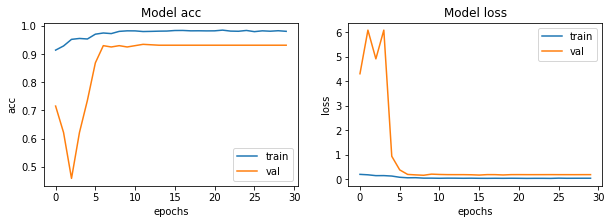

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline
fig, ax = plt.subplots(1, 2, figsize=(10, 3))
ax = ax.ravel()

for i, met in enumerate(['acc', 'loss']):
    ax[i].plot(history_pretrained.history[met])
    ax[i].plot(history_pretrained.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])